## Restore and generation¶
Construct a Graph as the same scope and names as the saved net;
Restore the saved session;
Estimate a gmm;
generate new samples

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from rcae.utils import utils
from rcae.block import Block

/home/mzx/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

## Initialize tf.placeholders 

In [4]:
x_in = tf.placeholder(tf.float32, shape=[None,28,28,1],name='inputs')
x_out = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='outputs')
code_length = 128
code = tf.placeholder(tf.float32, shape=[None,code_length],name='code')

is_training = tf.placeholder(tf.bool, name='is_training')

## Encoder part

In [5]:
# Reisudal blocks
encode_flag = True
net = x_in
odd_flags = []
blocks_en = [
    [(16, 8, 2)],
    [(32, 16, 2)],
]
odd_flags = []
for i, block in enumerate(blocks_en):
    block_params = utils.get_block_en(block, is_training=is_training)
    # build the net
    block_obj = Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=encode_flag,
        scope = 'block'+str(i),
        summary_flag = True
        )
    net, odd_flag = block_obj.get_block()
    odd_flags.append(odd_flag)

(?, 14, 14, 16)
(?, 7, 7, 32)


In [6]:
# get shape of last block
encode_last_block_shape = net.get_shape()

In [7]:
# flatten layer
with tf.name_scope('flatten_en'):
    net = layers.flatten(net)
    tf.summary.histogram('flatten_en',net)
flatten_length = int(net.get_shape()[-1])

### Coder layer, i.e., the feature vector

In [8]:
with tf.name_scope('encoder_layer'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=code_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('encode_layer',net)
    code = net

## Decoder block

In [9]:
with tf.name_scope('flatten_de'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=flatten_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('flatten_de', net)

In [10]:
# flatten to convolve
with tf.name_scope('flatten_to_conv'):
    net = tf.reshape(
        net, 
        [-1, int(encode_last_block_shape[1]), 
         int(encode_last_block_shape[2]), int(encode_last_block_shape[3])])

In [11]:
# Residual blocks
block_list, block_stride = utils.get_block_list(blocks_en, input_depth=1)
blocks_de = utils.get_block_de_params(block_list, block_stride)

blocks_de_tmp = blocks_de.copy()
odd_flags_de = utils.get_odd_flags(odd_flags, blocks=blocks_de_tmp)

for i, block in enumerate(blocks_de):
    block_params = utils.get_block_de(block, is_training=is_training)
    # build the net
    block_obj = Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=False,
        scope = 'block'+str(i),
        summary_flag = True,
        odd_flags=odd_flags_de[i]
        )
    net = block_obj.get_block()
x_out = net

(?, 14, 14, 16)
(?, 28, 28, 1)


## Loss function, learning rate and training operations

In [12]:
# loss function
with tf.name_scope('loss'):
    cost = tf.reduce_mean(tf.square(x_out-x_in))
    tf.summary.scalar('loss', cost)

In [13]:
# learning rate: exponentially decaying
with tf.name_scope('learning_rate'):
    init_lr = tf.placeholder(tf.float32, name='LR')
    global_step = tf.placeholder(tf.float32, name="global_step")
    decay_step = tf.placeholder(tf.float32, name="decay_step")
    decay_rate = tf.placeholder(tf.float32, name="decay_rate")
    learning_rate = tf.train.exponential_decay(
        learning_rate = init_lr ,
        global_step = global_step,
        decay_steps = decay_step,
        decay_rate = decay_rate,
        staircase=False,
        name=None)   

In [14]:
# Train step 
# note: should add update_ops to the train graph
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

In [15]:
# load sess
foldname = "rcae_mnist"
name = 'rcae.pkl'
sess, name = utils.load_net(os.path.join(foldname, name))

INFO:tensorflow:Restoring parameters from ./rcae_mnist/model_rcae.ckpt


## Load data and get feature

In [16]:
# Step1 load MNITST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", 
                                  one_hot=False,
                                  validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
imgs,labels = mnist.train.images, mnist.train.labels

In [18]:
imgs = imgs.reshape(-1, 28, 28, 1)

In [19]:
# Get code: batchly
idx5 = np.where(labels==5)[0]
digit5 = np.zeros((len(idx5), code_length))
batchsize = 100
numbatch = len(idx5) // batchsize
for i in range(numbatch):
    digit5[i*batchsize: (i+1)*batchsize] = sess.run(
            code, feed_dict={x_in: imgs[idx5[i*batchsize:(i+1)*batchsize]], 
                             is_training: False}
    )

In [20]:
gmm5 = utils.getGMM(
    data=digit5, n_components=11, covariance_type='full')

In [21]:
# test a image
n_examples = 10
code_sim5 = gmm5.sample(n_samples=n_examples)[0]
img_sim5 = sess.run(x_out, 
                       feed_dict={x_in: np.zeros((n_examples,28,28,1)), 
                                  code: code_sim5, 
                                  is_training: False})

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


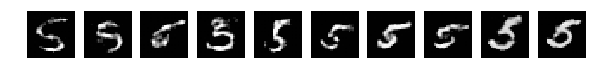

In [22]:
fig, axs = plt.subplots(1, n_examples, figsize=(n_examples, 1))
for example_i in range(n_examples):
    # original
    axs[example_i].imshow(np.reshape(img_sim5[example_i, :], (28, 28)), cmap='gray')
    axs[example_i].axis('off')

fig.show()
plt.draw()